<a href="https://colab.research.google.com/github/mbilalazam/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/00_mpi_pi_bilal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel computing
**Parallel computing** refers to the process of breaking down larger problems into smaller, independent, often similar parts that can be executed simultaneously by multiple processors communicating via network or shared memory, the results of which are combined upon completion as part of an overall algorithm.

## $\pi$ example
We can calculate the value of $\pi$ using a MPI parallelized version of the Monte Carlo method. The basic idea is to estimate $\pi$ by randomly sampling points within a square and determining how many fall inside a quarter circle inscribed within that square.

![PI](https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png)

3.216
Time: 102.45145273208618


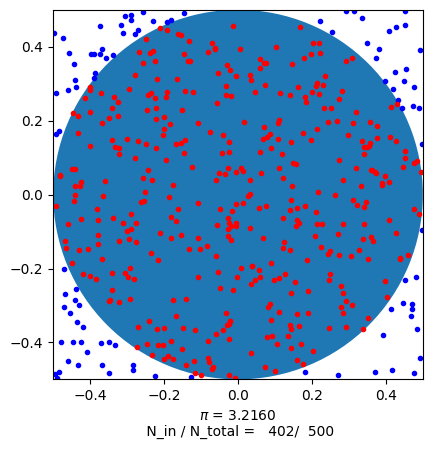

In [2]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(res/float(N/4.0))
print("Time: %s" %(t1 - t0))

### MPI example
```python
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))
```

### Running $\pi$ example on Google Colab

In [13]:
! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py

--2024-03-28 21:06:27--  https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555 [text/plain]
Saving to: ‘mpi_pi.py.2’

mpi_pi.py.2         100%[===================>]     555  --.-KB/s    in 0s      

2024-03-28 21:06:27 (21.4 MB/s) - ‘mpi_pi.py.2’ saved [555/555]



In [36]:
#! wget https://raw.githubusercontent.com/mbilalazam/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py
! wget -O mpi_pi.py https://raw.githubusercontent.com/mbilalazam/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py

--2024-03-28 21:15:33--  https://raw.githubusercontent.com/mbilalazam/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1181 (1.2K) [text/plain]
Saving to: ‘mpi_pi.py’

mpi_pi.py           100%[===================>]   1.15K  --.-KB/s    in 0s      

2024-03-28 21:15:33 (72.5 MB/s) - ‘mpi_pi.py’ saved [1181/1181]



In [37]:
! mpirun -np 1 --allow-run-as-root python mpi_pi.py

Estimated π: 3.1422048
Time: 9.599051713943481 seconds
Total number of points (N): 5000000


In [39]:
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 500
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(0, dtype='d') # Initialize res_tot for clarity
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank == 0:
    print(f"Estimated π: {res_tot/float(N/4.0)}")
    print(f"Time: {t1 - t0} seconds")
    print(f"Total number of points (N): {N}")

Estimated π: 3.088
Time: 0.003793954849243164 seconds
Total number of points (N): 500


In [12]:
! mpirun -np 2 --allow-run-as-root python mpi_pi.py

--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 2
slots that were requested by the application:

  python

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manager (e.g., SLURM, PBS/Torque, LSF, etc.)
  4. If none of a hostfile, the --host command line parameter, or an
     RM is present, Open MPI defaults to the number of processor cores

In all the above cases, if you want Open MPI to default to the number
of hardware threads instead of the number of

In [ ]:
! mpirun -np 4 python mpi_pi.py

### Running $\pi$ on Polaris
```bash
ssh <username>@polaris.alcf.anl.gov
qsub -A ALCFAITP -l select=1 -q debug -l walltime=0:30:00 -l filesystems=home:eagle
module load conda/2023-10-04
conda activate /soft/datascience/ALCFAITP/2023-10-04
git clone git@github.com:argonne-lcf/ai-science-training-series.git
cd ai-science-training-series/01_intro_AI_on_Supercomputer/
mpirun -np 1 python mpi_pi.py   # 3.141988,   8.029037714004517  s
mpirun -np 2 python mpi_pi.py   # 3.1415096   4.212774038314819  s
mpirun -np 4 python mpi_pi.py   # 3.1425632   2.093632459640503  s
mpirun -np 8 python mpi_pi.py   # 3.1411632   1.0610620975494385 s
```

## Parallel computing in AI

**AI = data + model**

* **Data parallelism** - different GPU work on different data
* **Model parallelism** - differetn GPU work on different part of the model
![PI](https://github.com/mbilalazam/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/parallel_computing.png?raw=1)